In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import barbershop

In [103]:
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
print(df.head(5))
print(df.columns)
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V

  #Gc logAge [M/H]    m_ini   logL  logTe   logg  m-M0   Av  m2/m1    mbol  \
0   1   6.65  0.09  0.74724 -0.773  3.659  4.669   9.4  0.0    0.0  16.103   
1   1   6.71 -0.03  1.02636 -0.105  3.753  4.511  13.2  0.0    0.0  18.232   
2   1   6.77  0.33  0.77965 -0.712  3.664  4.643   9.8  0.0    0.0  16.351   
3   1   6.81  0.07  1.63295  0.850  3.881  4.271   6.9  0.0    0.0   9.546   
4   1   6.81  0.13  1.74446  0.965  3.899  4.256   9.1  0.0    0.0  11.457   

        U       B       V       R       I       J       H       K   Mact  
0  18.624  17.703  16.613  15.938  15.409  14.655  14.031  13.954  0.747  
1  19.209  19.019  18.312  17.909  17.568  17.122  16.761  16.724  1.026  
2  18.919  17.942  16.839  16.167  15.644  14.904  14.303  14.228  0.780  
3   9.761   9.759   9.501   9.350   9.222   9.085   8.985   8.975  1.633  
4  11.649  11.619  11.408  11.292  11.199  11.098  11.028  11.019  1.744  
Index(['#Gc', 'logAge', '[M/H]', 'm_ini', 'logL', 'logTe', 'logg', 'm-M0',
      

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


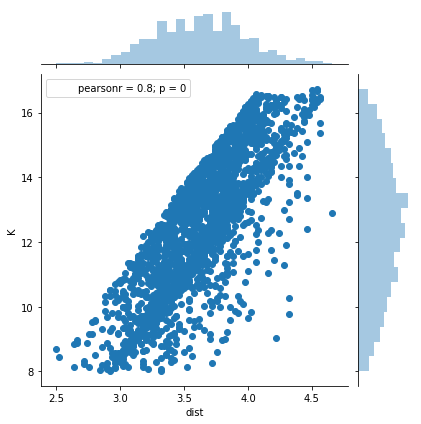

In [105]:
sns.jointplot(np.log10(df.dist), df.K)

In [106]:
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


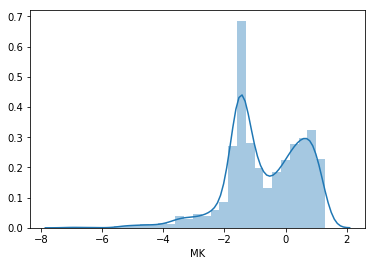

In [107]:
sns.distplot(df.MK)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


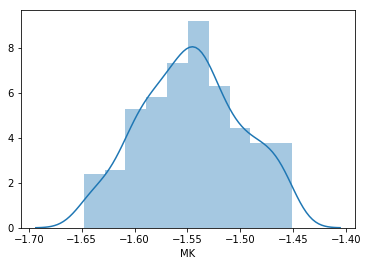

In [112]:
df = df.loc[np.abs(df.MK + 1.55) < 0.1]
sns.distplot(df.MK)

In [99]:
import pystan
code = '''
data {
    int<lower = 0> N;
    real M_obs[N];
    real M_unc[N];
}
parameters {
    real M_std[N];
    real mu;
    real<lower = 0> sigma;
    real<lower = 0> nu;
}
transformed parameters{
    real M_true[N];
    real<lower = 0.001> un;
    for (i in 1:N)
        M_true[i] = M_std[i] * sigma + mu;
    un = 1.0 / nu;
}
model{
    M_std ~ student_t(nu, 0, 1);
    M_obs ~ normal(M_true, M_unc);
    mu ~ normal(-1.61, 0.1);
    sigma ~ normal(0, 0.1);
    un ~ normal(0, 0.3);
}

'''
sm = pystan.StanModel(model_code=code, model_name='ClumpModel')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ClumpModel_b6be126fbac7b8b601a99bca02e2376f NOW.


In [125]:
err = np.ones(len(df)) * 0.3
MK = df.MK + np.random.randn(len(df))*err
dat = {'N': len(MK),
      'M_obs': MK,
      'M_unc': err}
fit = sm.sampling(data=dat, iter=6000, chains=4)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


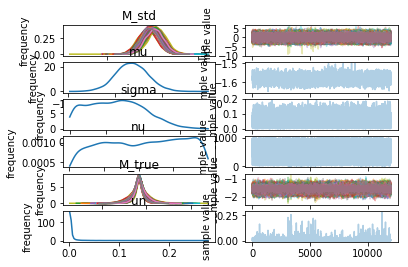

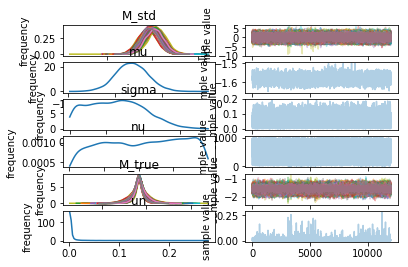

In [126]:
fit.plot()

In [127]:
print(fit)

Inference for Stan model: ClumpModel_b6be126fbac7b8b601a99bca02e2376f.
4 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
M_std[0]     -0.06    0.03   0.96  -1.96  -0.69  -0.04   0.57    1.8   1234    1.0
M_std[1]      0.01    0.03   0.98  -1.92  -0.63 7.2e-3   0.69   1.89   1157    1.0
M_std[2]     -0.09    0.03   0.97  -2.05  -0.73  -0.08   0.56   1.82   1190    1.0
M_std[3]      0.02    0.03   0.98  -1.92  -0.61   0.02   0.67   1.97   1207   1.01
M_std[4]      0.07    0.03   0.99  -1.82   -0.6   0.07   0.76   1.95   1408   1.01
M_std[5]     -0.08    0.03   0.98  -2.02  -0.72  -0.06   0.56   1.86   1315    1.0
M_std[6]      0.23    0.03   0.97  -1.66  -0.43   0.22   0.87   2.13   1109    1.0
M_std[7]       0.2    0.03   0.98  -1.71  -0.45    0.2   0.85   2.08   1038    1.0
M_std[8]      0.21    0.03   0.97  -1.74  -0.41   0.21   0.88  